In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
import pandas as pd

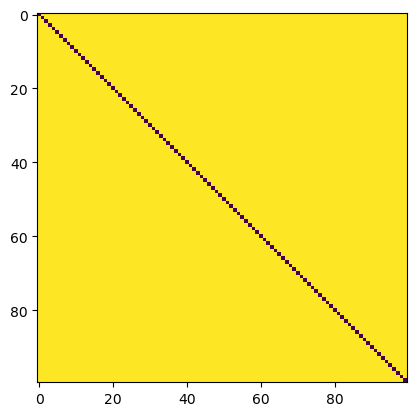

In [2]:
n = 100
dt = 0.001
T = 1

# default, connected
A = np.ones((n,n))
A = np.triu(A, 1)
A = A + A.T

# Erdos Renyi
# p = .2
# A = np.random.rand(n,n) # random matrix
# A = np.where(A < p, 1, 0) # adjacency matrix
# A = np.triu(A, 1) # triangular matrix
# A = A + A.T # symmetric matrix

# Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0

# plot

#Simulating for the Barbell Population Model with a Stopping Criterion
# pop = np.random.randint(25,75) #minimum and maximum population sizes
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             A[i,j] = 0
#         elif (i <= pop and j <= pop) or (i > pop and j > pop):
#             A[i,j] = 1
#         else:
#             A[i,j] = 0
# sender = np.random.randint(0,pop+1)
# receiver = np.random.randint(pop+1,99)
# A[sender,receiver] = 1
# A[receiver,sender] = 1

plt.imshow(A)
plt.show()

## Second Approach to Accumulation of Private Information

$\frac{dy_j}{dt} = \pm \mu dt + \sqrt{2\mu}dW_j(t) + \frac{dL(t)}{dt}$, where $L(t) = \ln(\frac{P(H_+)}{P(H_-)})$ at time t, where the $P(H_+)$ and $P(H_-)$ are given by a logistic classification model built on previous rounds of training samples.

In [46]:
# Creating a set of uniformly distributed thresholds that lie between a minimum and maximum threshold, dealer's choice for how wide this interval is
T = 1
per = 10

# initial conditions
y = np.zeros((n, int(T/dt)))

# Simulating a run of the agents
def sim(y0,Adj,thetas,mu,period,N,Time,delta_t,FeatFunc,stop,wavestop = False,tstop = False,model = False):
    kicks = np.zeros(N) #Easy way to tell when some agent has kicked
    neighbors = np.zeros(N) #This is going to be a weighted average of the thresholds of the neighbors that have decided
    train = [] #Training data for the model
    # simulation
    firstkick = N*[0]
    LLR = np.zeros(N)
    pkicks = np.zeros(N)
    wv = 0
    for t in range(1,int(Time/delta_t)):
        
        wvnew = wv
        
        if t >= 2:
            pkicks = np.array([y0[ind,t-2]/abs(y0[ind,t-2]) if abs(y0[ind,t-2]) >= thetas[ind] else 0 for ind in range(N)])
            
        sk = sum(abs(kicks))
        psk = sum(abs(pkicks))
        features = FeatFunc(y0,Adj,firstkick,kicks,pkicks,thetas,N)
        
        if model: #If we actually have a model to use to form a Log-Likelihood ratio, then you need to predict the correct decision
            res = model.predict_proba(np.array(features))
        
        # Update Kicks and The State
        newk = [thetas[i]*kicks[i] for i in range(N)]
        pk = [thetas[i]*pkicks[i] for i in range(N)]
        if sk > psk:
            LLPrev = LLR.copy()
        
        for yj in range(N):
            if abs(y0[yj,t-1]) < thetas[yj]:
                y0[yj,t] = y0[yj,t-1] + delta_t*mu + np.sqrt(2*abs(mu)*delta_t)*np.random.normal(0.0,1)
                
                if sk > psk:
                    if model:
                        r0,r1 = res[yj]
                        LLR[yj] = np.log(r1/r0) if r0 > 1e-10 else 6

                        if LLR[yj] > 6:
                            LLR[yj] = 6
                        elif LLR[yj] < -6:
                            LLR[yj] = -6
                            
                    y0[yj,t] += (LLR[yj]-LLPrev[yj])
                    
                if y0[yj,t] <= -1*thetas[yj]: #If the new predicted information for an agent is outside of their threshold
                    #Then they make a decision, and they're registered as having "kicked"
                    y0[yj,t] = -1
                    kicks[yj] = -1
                if y0[yj,t] >= thetas[yj]:
                    y0[yj,t] = 1
                    kicks[yj] = 1
                #else:
                 #   kicks[yj] = 0
            else:
                y0[yj,t] = y0[yj,t-1]
                
        if wavestop:
            if sk < sum(abs(kicks)):
                wv += 1
            if wv == wvnew and wv > 1:
                break
                
        while sk != sum(abs(kicks)):
            sk = sum(abs(kicks))
            
            features = FeatFunc(y0,Adj,firstkick,kicks,pkicks,thetas,N)
            
            LLPrev = LLR.copy()
            if model: #If we actually have a model to use to form a Log-Likelihood ratio, then you need to predict the correct decision
                res = model.predict_proba(np.array(features))
                for m in range(N):
                    LLR[m] = np.log(res[m][1]/res[m][0]) if res[m][0] != 0 else 0
                    if LLR[yj] > 6:
                        LLR[yj] = 6
                    elif LLR[yj] < -6:
                        LLR[yj] = -6
                    
            for yj in range(N):
                
                if abs(y0[yj,t]) < thetas[yj]: 
                    y0[yj,t] = y0[yj,t] + (LLR[yj]-LLPrev[yj])
                
                    if y0[yj,t] <= -1*thetas[yj]: #If the new predicted information for an agent is outside of their threshold
                        #Then they make a decision, and they're registered as having "kicked"
                        y0[yj,t] = -1
                        kicks[yj] = -1
                    if y0[yj,t] >= thetas[yj]:
                        y0[yj,t] = 1
                        kicks[yj] = 1
                    #else:
                     #   kicks[yj] = 0
            
            if sum(abs(kicks)) >= stop: #If a certain threshold of people have decided, then end the sim
                break
            
        if t%period == 0: #Set a period along which you want training samples to be collected
            train += features
                
        if sum(abs(kicks)) >= stop: #If a certain threshold of people have decided, then end the sim
                break
        if tstop: #If there's a time threshold
            if t >= tstop: #If a certain threshold of time has passed, end the sim
                break

    return train,y0,t #This returns  a training dataset, the simulated behavior, and the time the sim ended

In [42]:
def ModelFeatures1(yvals,Adj,fk,k,pk,th,num):
    stuff = []
    for j in range(num):
        B = [] 
        #This function here is going through and finding whether a decision has been made by a neighbor
        #Using the adjacency matrix, and then summing up the thresholds multiplied by the decision that was made (1,-1,0)
        #Then, to form the average, this weighted sum is divided by the total number of neighbors nearby
        B = []
        diff = k-pk
        count = 0
        for i in range(num):
            if diff[i] < 0:
                B += [-1 if Adj[i,j]*diff[i] < -1 else Adj[i,j]*diff[i]]
                count += 1
            elif diff[i] > 0:
                B += [1 if Adj[i,j]*diff[i] > 1 else Adj[i,j]*diff[i]]
                count += 1
            else:
                B += [0]
        if fk[j] != 0:
            fkick = [th[l]*yvals[l,fk[j]] if abs(yvals[l,fk[j]]) >= 1 else 0 for l in range(num)]
        else:
            fkick = np.zeros(num)
            
        stuff += [[B@th/count if count != 0 else 0,Adj[:,j]@diff,fk[j],Adj[:,j]@fkick]]
    return stuff

def ModelFeatures2(yvals,Adj,fk,k,pk,th,num):
    stuff = []
    for j in range(num):
        B = [] 
        #This function here is going through and finding whether a decision has been made by a neighbor
        #Using the adjacency matrix, and then summing up the thresholds multiplied by the decision that was made (1,-1,0)
        #Then, to form the average, this weighted sum is divided by the total number of neighbors nearby
        B = []
        C = []
        diff = k-pk
        count = 0
        ctot = 0
        for i in range(num):
            if diff[i] < 0:
                B += [-1 if Adj[i,j] > 0 else 0]
                count += 1
            elif diff[i] > 0:
                B += [1 if Adj[i,j] > 0 else 0]
                count += 1
            else:
                B += [0]
        for i2 in range(num):
            if k[i2] < 0:
                C += [-1 if Adj[i2,j] > 0 else 0]
                ctot += 1
            elif k[i2] > 0:
                C += [1 if Adj[i2,j] > 0 else 0]
                ctot += 1
            else:
                C += [0]
                
        if fk[j] != 0:
            fkick = [th[l]*yvals[l,fk[j]] if abs(yvals[l,fk[j]]) >= 1 else 0 for l in range(num)]
        else:
            fkick = np.zeros(num)
            
        tn = sum(Adj[:,j])
        stuff += [[B@th/count if count != 0 else 0,Adj[:,j]@diff,C@th/tn,k@Adj[:,j],min(th)]]
    return stuff

def RR(yvec,correct,tstop): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = 0
    inc = 0
    und = 0
    for i in yvec:
        if i == correct:
            cor += 1
        elif i == -1*correct:
            inc += 1
        else:
            und += 1
    return (cor/(inc+und+cor))/tstop

In [49]:
trainacc = []
trainRR = []
Xtrain = []
ytrain = []
for i in np.arange(0.01,1.01,0.01):
    thresh = np.array([np.random.uniform(i,0.9) for _ in range(n)])
    for j in [-1,1]:
        training,ysim,tstop = sim(y,A,thresh,j,per,n,1,dt,ModelFeatures2,True,80,tstop=False,model = False)
        Xtrain += training
        ytrain += len(training)*[j]
        trainacc += [list(ysim[:,tstop]).count(j)/len(ysim)]
        trainRR += [RR(ysim[:,tstop],j,tstop)]
        print(f'Check {i}, for {j}')

Check 0.01, for -1
Check 0.01, for 1
Check 0.02, for -1
Check 0.02, for 1
Check 0.03, for -1
Check 0.03, for 1
Check 0.04, for -1
Check 0.04, for 1
Check 0.05, for -1
Check 0.05, for 1
Check 0.060000000000000005, for -1
Check 0.060000000000000005, for 1
Check 0.06999999999999999, for -1
Check 0.06999999999999999, for 1
Check 0.08, for -1
Check 0.08, for 1
Check 0.09, for -1
Check 0.09, for 1
Check 0.09999999999999999, for -1
Check 0.09999999999999999, for 1
Check 0.11, for -1
Check 0.11, for 1
Check 0.12, for -1
Check 0.12, for 1
Check 0.13, for -1
Check 0.13, for 1
Check 0.14, for -1
Check 0.14, for 1
Check 0.15000000000000002, for -1
Check 0.15000000000000002, for 1
Check 0.16, for -1
Check 0.16, for 1
Check 0.17, for -1
Check 0.17, for 1
Check 0.18000000000000002, for -1
Check 0.18000000000000002, for 1
Check 0.19, for -1
Check 0.19, for 1
Check 0.2, for -1
Check 0.2, for 1
Check 0.21000000000000002, for -1
Check 0.21000000000000002, for 1
Check 0.22, for -1
Check 0.22, for 1
Check 

In [9]:
def TrainData(labels,data,truevals):
    df = []
    for index in range(len(data)):
        df += [data[index]+[truevals[index]]]
    
    df = pd.DataFrame(df, columns = labels, dtype = float)
    
    return df

df = TrainData(['Aggregate','NewDecision','AggregateTot','TotDec','THMin','True'],Xtrain,ytrain)

def SocialLC(data,xlabs,ylab):

    X = np.array(data[xlabs])
    ydat = data[ylab]
    model = LogisticRegression()
    model.fit(X, ydat)
    
    return model

logreg = SocialLC(df,['Aggregate','NewDecision','AggregateTot','TotDec','THMin'],'True')

In [47]:
rewards = []
accuracy = []
Xtest = []
ytest = []
for i in np.arange(0,1.01,0.05):
    thresh = np.array([np.random.uniform(i,0.9) for j in range(n)])
    rr = []
    acc = []
    for _ in range(100):
        true = np.random.choice([-1,1])
        training5,ysim5,tstop5 = sim(np.zeros((100, int(1/0.001))),A,thresh,true,10,100,1,0.001,ModelFeatures2,True,80,1000,model = logreg)
        Xtest += [training5]
        ytest += [len(training5)*[true]]
        acc += [list(ysim5[:,tstop5]).count(true)/len(ysim5)]
        rr += [RR(ysim5[:,tstop5],true,tstop5)]
        #print(f'Minimum Theta {i}, sim accuracy: {list(ysim5[:,tstop5]).count(true)/len(ysim5)}')
    rewards += [sum(rr)/len(rr)]
    accuracy += [sum(acc)/len(acc)]
    print(f'Minimum Theta {i}')

Minimum Theta 0.0
Minimum Theta 0.05
Minimum Theta 0.1
Minimum Theta 0.15000000000000002
Minimum Theta 0.2
Minimum Theta 0.25
Minimum Theta 0.30000000000000004
Minimum Theta 0.35000000000000003
Minimum Theta 0.4
Minimum Theta 0.45
Minimum Theta 0.5
Minimum Theta 0.55
Minimum Theta 0.6000000000000001
Minimum Theta 0.65
Minimum Theta 0.7000000000000001
Minimum Theta 0.75
Minimum Theta 0.8
Minimum Theta 0.8500000000000001
Minimum Theta 0.9
Minimum Theta 0.9500000000000001
Minimum Theta 1.0


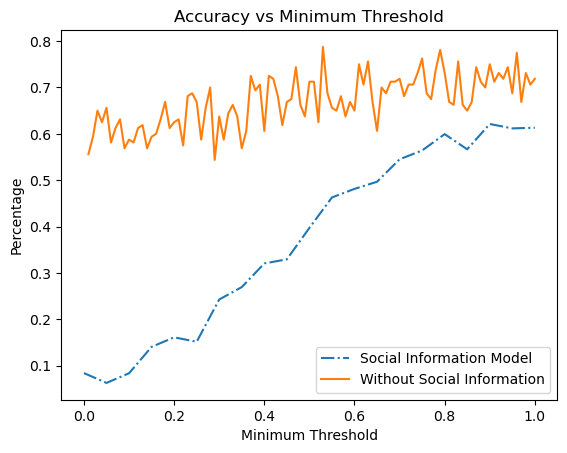

In [48]:
plt.plot(np.arange(0,1.05,0.05),[100*a/80 for a in accuracy],'-.',label = 'Social Information Model')
plt.plot(np.arange(0.01,1.01,0.01),[100*(trainacc[i]+trainacc[i+1])/(2*80) for i in range(0,len(trainacc),2)],label = 'Without Social Information')
plt.xlabel('Minimum Threshold')
plt.ylabel('Percentage')
plt.title('Accuracy vs Minimum Threshold')
plt.legend()
plt.show()

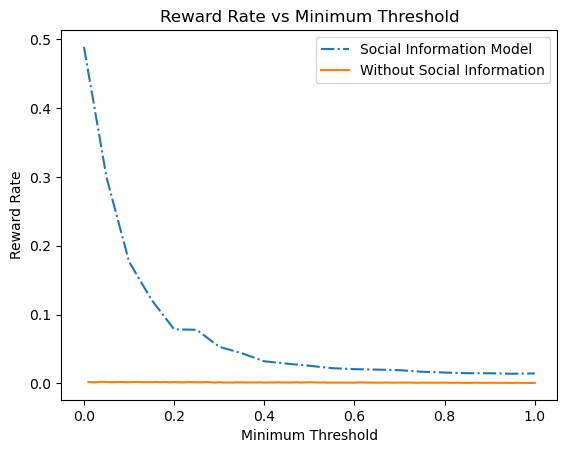

In [35]:
plt.plot(np.arange(0,1.05,0.05),rewards,'-.',label = 'Social Information Model')
plt.plot(np.arange(0.01,1.01,0.01),[(trainRR[i]+trainRR[i+1])/2 for i in range(0,len(trainRR),2)],label = 'Without Social Information')
plt.xlabel('Minimum Threshold')
plt.ylabel('Reward Rate')
plt.title('Reward Rate vs Minimum Threshold')
plt.legend()
plt.show()

In [71]:
Xtrain

[[0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.004272759067476908, -5.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.0044511732907871904, -6.0],
 0.016468288676423855,
 [0.05272765938331645, 0.0, -0.003741211238033531, -5.0],
 0.016468288676423855,
 [0.05272765938331

In [256]:
Xt = []
for i in Xtest:
    Xt += i
yt = []
for i in ytest:
    yt += i

In [274]:
#logreg.predict(np.array(Xt[0]).reshape(-1, 1))
preds = logreg.predict_proba(np.array(Xt))
preds[0]

array([0.69580183, 0.30419817])

In [258]:
cnt = 0
for i in range(len(Xt)):
    if preds[i] != yt[i]:
        cnt += 1

In [259]:
len(yt)-cnt

80166

In [260]:
(len(yt)-cnt)/len(yt)

0.9509608540925267

In [16]:
df.to_csv('C:\\Users\\alden\\Downloads\\CompNeuroTraining.csv', index=False)

In [17]:
import pickle

# save
with open('C:\\Users\\alden\\Downloads\\logclass.pkl','wb') as f:
    pickle.dump(logreg,f)

# load
#with open('logclass.pkl', 'rb') as f:
#    model = pickle.load(f)

In [320]:
xtrain

In [14]:
import os
cwd = os.getcwd()

In [15]:
cwd

'C:\\Users\\alden\\APPM 5370'

In [39]:
a = [1,2,3]
b = [2,3,4]
a += b

[1, 2, 3, 2, 3, 4]

In [ ]:
#TODO Need to Update This Commented Out Stuff
# rewards = []
# accuracy = []
# testXdat = []
# testydat = []
# for i in np.arange(10,201,1):
#     true = np.random.choice([-1,1])
#     training5,ysim5,tstop5 = sim(np.zeros((100, int(1/0.001))),A,thresh,true,10,100,1,0.001,ModelFeatures2,100,i,model = logreg)
#     testXdat += [training5]
#     testydat += [len(training5)*[true]]
#     accuracy += [list(ysim5[:,tstop5]).count(true)/len(ysim5)]
#     rewards += [RR(ysim5[:,tstop5],true,tstop5)]
#     print(f'Stopping Time {i}')